# Principal Component Analysis Lab

## Part 1: Work through the steps of PCA on a sample dataset

### Visualization 1: Two-dimensional Gaussians

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def prepare_plot(xticks, yticks, figsize=(10.5, 6), hide_labels=False, grid_color='#999999',
                 grid_width=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hide_labels: axis.set_ticklabels([])
    plt.grid(color=grid_color, linewidth=grid_width, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

def create_2D_gaussian(mn, variance, cov, n):
    """Randomly sample points from a two-dimensional Gaussian distribution"""
    np.random.seed(142)
    return np.random.multivariate_normal(np.array([mn, mn]), np.array([[variance, cov], [cov, variance]]), n)

/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


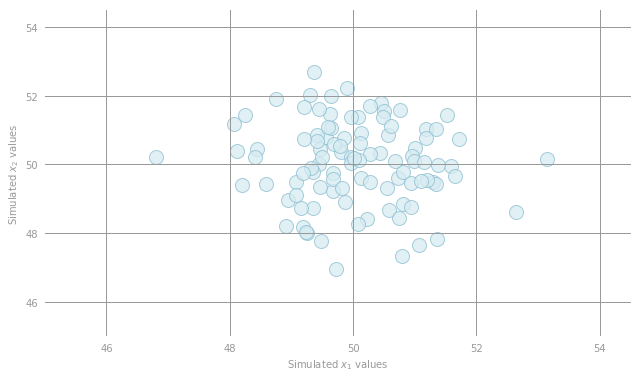

In [2]:
data_random = create_2D_gaussian(mn=50, variance=1, cov=0, n=100)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45, 54.5), ax.set_ylim(45, 54.5)
plt.scatter(data_random[:,0], data_random[:,1], s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
fig.show()

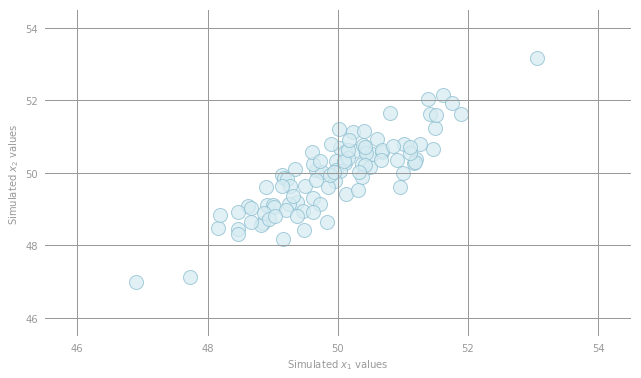

In [3]:
data_correlated = create_2D_gaussian(mn=50, variance=1, cov=.9, n=100)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.scatter(data_correlated[:,0], data_correlated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
fig.show()

### (1a) Interpreting PCA

In [4]:
correlated_data = sc.parallelize(data_correlated)

mean_correlated = correlated_data.sum() / correlated_data.count()
correlated_data_zero_mean = correlated_data.map(lambda x: x - mean_correlated)

print(mean_correlated)
print(correlated_data.take(1))
print(correlated_data_zero_mean.take(1))

[ 49.95739037  49.97180477]
[array([ 49.6717712 ,  50.07531969])]
[array([-0.28561917,  0.10351492])]


### (1b) Sample covariance matrix

In [5]:
# Compute the covariance matrix using outer products and correlated_data_zero_mean
(cov, count) = correlated_data_zero_mean.map(lambda x: (np.outer(x, x), 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
correlated_cov = cov / count
print(correlated_cov)

[[ 0.99558386  0.90148989]
 [ 0.90148989  1.08607497]]


### (1c) Covariance Function

In [6]:
def estimate_covariance(data):
    """Compute the covariance matrix for a given rdd.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        data (RDD of np.ndarray):  An `RDD` consisting of NumPy arrays.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input `RDD`.
    """
    mean_correlated = data.sum() / data.count()
    correlated_data_zero_mean = data.map(lambda x: x - mean_correlated)
    (cov, count) = correlated_data_zero_mean.map(lambda x: (np.outer(x, x), 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    return cov / count

correlated_cov_auto= estimate_covariance(correlated_data)
print(correlated_cov_auto)

[[ 0.99558386  0.90148989]
 [ 0.90148989  1.08607497]]


### (1d) Eigendecomposition

In [7]:
from numpy.linalg import eigh

# Calculate the eigenvalues and eigenvectors from correlated_cov_auto
eig_vals, eig_vecs = eigh(correlated_cov_auto)
print('eigenvalues: {0}'.format(eig_vals))
print('\neigenvectors: \n{0}'.format(eig_vecs))

# Use np.argsort to find the top eigenvector based on the largest eigenvalue
inds = np.argsort(eig_vals)
top_component = eig_vecs[:,inds[len(inds)-1]]
print('\ntop principal component: {0}'.format(top_component))

eigenvalues: [ 0.13820481  1.94345403]

eigenvectors: 
[[-0.72461254  0.68915649]
 [ 0.68915649  0.72461254]]

top principal component: [ 0.68915649  0.72461254]


### (1e) PCA scores

In [8]:
# Use the top_component and the data from correlated_data to generate PCA scores
correlated_data_scores = correlated_data.map(lambda x: x.dot(top_component))
print('one-dimensional data (first three):\n{0}'.format(np.asarray(correlated_data_scores.take(3))))

one-dimensional data (first three):
[ 70.51682806  69.30622356  71.13588168]


## Part 2: Write a PCA function and evaluate PCA on sample datasets

### (2a) PCA function

In [9]:
def pca(data, k=2):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        data (RDD of np.ndarray): An `RDD` consisting of NumPy arrays.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
            scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
            rows equals the length of the arrays in the input `RDD` and the number of columns equals
            `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
            of length `k`.  Eigenvalues is an array of length d (the number of features).
    """
    correlated_cov_auto= estimate_covariance(data)
    eig_vals, eig_vecs = eigh(correlated_cov_auto)
    inds = np.argsort(eig_vals)
    topk = None
    l = len(inds)
    for i in range(k):
        if topk is None:
            topk = eig_vecs[:,inds[l-i-1]]
        else:
            topk = np.vstack((topk,eig_vecs[:,inds[l-i-1]]))
    correlated_data_scores = data.map(lambda x: x.dot(topk.T))
    # Return the `k` principal components, `k` scores, and all eigenvalues
    eig_vals = sorted(eig_vals, reverse=True)
    return topk.T, correlated_data_scores, eig_vals

# Run pca on correlated_data with k = 2
top_components_correlated, correlated_data_scores_auto, eigenvalues_correlated = pca(correlated_data)

# Note that the 1st principal component is in the first column
print('top_components_correlated: \n{0}'.format(top_components_correlated))
print('\ncorrelated_data_scores_auto (first three): \n{0}'
       .format('\n'.join(map(str, correlated_data_scores_auto.take(3)))))
print('\neigenvalues_correlated: \n{0}'.format(eigenvalues_correlated))

# Create a higher dimensional test set
pca_test_data = sc.parallelize([np.arange(x, x + 4) for x in np.arange(0, 20, 4)])
components_test, test_scores, eigenvalues_test = pca(pca_test_data, 3)

print('\npca_test_data: \n{0}'.format(np.array(pca_test_data.collect())))
print('\ncomponents_test: \n{0}'.format(components_test))
print('\ntest_scores (first three): \n{0}'
       .format('\n'.join(map(str, test_scores.take(3)))))
print('\neigenvalues_test: \n{0}'.format(eigenvalues_test))

top_components_correlated: 
[[ 0.68915649 -0.72461254]
 [ 0.72461254  0.68915649]]

correlated_data_scores_auto (first three): 
[ 70.51682806  -1.48305648]
[ 69.30622356  -1.5888655 ]
[ 71.13588168  -1.86710679]

eigenvalues_correlated: 
[1.943454028375323, 0.13820480733404228]

pca_test_data: 
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]

components_test: 
[[  5.00000000e-01  -7.41676339e-18  -3.43150291e-01]
 [  5.00000000e-01  -2.66963658e-16  -6.35281904e-01]
 [  5.00000000e-01  -7.07106781e-01   4.89216098e-01]
 [  5.00000000e-01   7.07106781e-01   4.89216098e-01]]

test_scores (first three): 
[ 3.          0.70710678  1.81079858]
[ 11.           0.70710678   1.81079858]
[ 19.           0.70710678   1.81079858]

eigenvalues_test: 
[128.0, -3.944304526105059e-31, -1.0958430794180699e-14, -3.1674133351425315e-14]


### (2b) PCA on `data_random`

In [10]:
random_data_rdd = sc.parallelize(data_random)

# Use pca on data_random
top_components_random, random_data_scores_auto, eigenvalues_random = pca(random_data_rdd)

print('top_components_random: \n{0}'.format(top_components_random))
print('\nrandom_data_scores_auto (first three): \n{0}'
       .format('\n'.join(map(str, random_data_scores_auto.take(3)))))
print('\neigenvalues_random: \n{0}'.format(eigenvalues_random))

top_components_random: 
[[-0.2522559  -0.96766056]
 [ 0.96766056 -0.2522559 ]]

random_data_scores_auto (first three): 
[ 36.61068572 -61.3489929 ]
[ 35.97314295 -62.08813671]
[ 35.59836628 -60.61390415]

eigenvalues_random: 
[1.420454601001893, 0.99521396869310241]


### Visualization 2: PCA projection

In [11]:
def project_points_and_get_lines(data, components, x_range):
    """Project original data onto first component and get line details for top two components."""
    top_component = components[:, 0]
    slope1, slope2 = components[1, :2] / components[0, :2]

    means = data.mean()[:2]
    demeaned = data.map(lambda v: v - means)
    projected = demeaned.map(lambda v: (v.dot(top_component) /
                                        top_component.dot(top_component)) * top_component)
    remeaned = projected.map(lambda v: v + means)
    x1,x2 = zip(*remeaned.collect())

    line_start_P1_X1, line_start_P1_X2 = means - np.asarray([x_range, x_range * slope1])
    line_end_P1_X1, line_end_P1_X2 = means + np.asarray([x_range, x_range * slope1])
    line_start_P2_X1, line_start_P2_X2 = means - np.asarray([x_range, x_range * slope2])
    line_end_P2_X1, line_end_P2_X2 = means + np.asarray([x_range, x_range * slope2])

    return ((x1, x2), ([line_start_P1_X1, line_end_P1_X1], [line_start_P1_X2, line_end_P1_X2]),
            ([line_start_P2_X1, line_end_P2_X1], [line_start_P2_X2, line_end_P2_X2]))

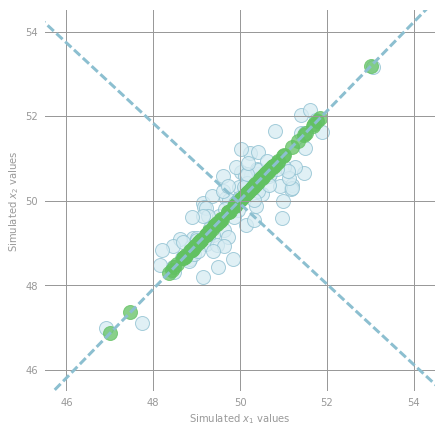

In [12]:
((x1, x2), (line1X1, line1X2), (line2X1, line2X2)) = \
    project_points_and_get_lines(correlated_data, top_components_correlated, 5)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2), figsize=(7, 7))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.scatter(data_correlated[:,0], data_correlated[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1, x2, s=14**2, c='#62c162', alpha=.75)
fig.show()

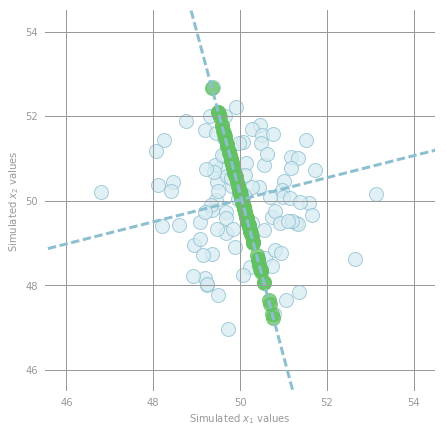

In [13]:
((x1, x2), (line1X1, line1X2), (line2X1, line2X2)) = \
    project_points_and_get_lines(random_data_rdd, top_components_random, 5)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(46, 55, 2), np.arange(46, 55, 2), figsize=(7, 7))
ax.set_xlabel(r'Simulated $x_1$ values'), ax.set_ylabel(r'Simulated $x_2$ values')
ax.set_xlim(45.5, 54.5), ax.set_ylim(45.5, 54.5)
plt.plot(line1X1, line1X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.plot(line2X1, line2X2, linewidth=3.0, c='#8cbfd0', linestyle='--')
plt.scatter(data_random[:,0], data_random[:,1], s=14**2, c='#d6ebf2',
            edgecolors='#8cbfd0', alpha=0.75)
plt.scatter(x1, x2, s=14**2, c='#62c162', alpha=.75)
fig.show()

### Visualization 3: Three-dimensional data

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


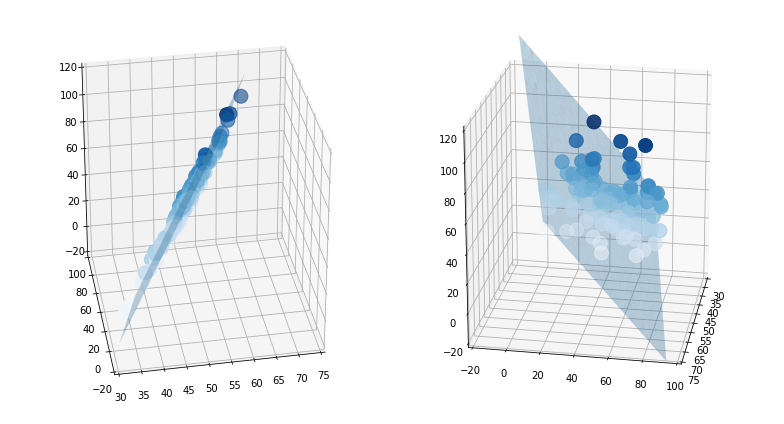

In [14]:
from mpl_toolkits.mplot3d import Axes3D

m = 100
mu = np.array([50, 50, 50])
r1_2 = 0.9
r1_3 = 0.7
r2_3 = 0.1
sigma1 = 5
sigma2 = 20
sigma3 = 20
c = np.array([[sigma1 ** 2, r1_2 * sigma1 * sigma2, r1_3 * sigma1 * sigma3],
             [r1_2 * sigma1 * sigma2, sigma2 ** 2, r2_3 * sigma2 * sigma3],
             [r1_3 * sigma1 * sigma3, r2_3 * sigma2 * sigma3, sigma3 ** 2]])
np.random.seed(142)
data_threeD = np.random.multivariate_normal(mu, c, m)

from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
norm = Normalize()
cmap = get_cmap("Blues")
clrs = cmap(np.array(norm(data_threeD[:,2])))[:,0:3]

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(121, projection='3d')
ax.azim=-100
ax.scatter(data_threeD[:,0], data_threeD[:,1], data_threeD[:,2], c=clrs, s=14**2)

xx, yy = np.meshgrid(np.arange(-15, 10, 1), np.arange(-50, 30, 1))
normal = np.array([0.96981815, -0.188338, -0.15485978])
z = (-normal[0] * xx - normal[1] * yy) * 1. / normal[2]
xx = xx + 50
yy = yy + 50
z = z + 50

ax.set_zlim((-20, 120)), ax.set_ylim((-20, 100)), ax.set_xlim((30, 75))
ax.plot_surface(xx, yy, z, alpha=.30)

ax = fig.add_subplot(122, projection='3d')
ax.azim=10
ax.elev=20
#ax.dist=8
ax.scatter(data_threeD[:,0], data_threeD[:,1], data_threeD[:,2], c=clrs, s=14**2)

ax.set_zlim((-20, 120)), ax.set_ylim((-20, 100)), ax.set_xlim((30, 75))
ax.plot_surface(xx, yy, z, alpha=.3)
plt.tight_layout()
fig.show()

### (2c) 3D to 2D

In [15]:
threeD_data = sc.parallelize(data_threeD)
components_threeD, threeD_scores, eigenvalues_threeD = pca(threeD_data)

print('components_threeD: \n{0}'.format(components_threeD))
print('\nthreeD_scores (first three): \n{0}'
       .format('\n'.join(map(str, threeD_scores.take(3)))))
print('\neigenvalues_threeD: \n{0}'.format(eigenvalues_threeD))

components_threeD: 
[[ 0.24222106  0.05945883]
 [ 0.61640177  0.76136584]
 [ 0.7492515  -0.6455902 ]]

threeD_scores (first three): 
[ 85.33933424  -7.87844277]
[ 89.7508907   16.19287096]
[ 76.00640043 -20.09388872]

eigenvalues_threeD: 
[614.46389707070773, 349.40763347637198, -3.2977350776608689e-14]


### Visualization 4: 2D representation of 3D data

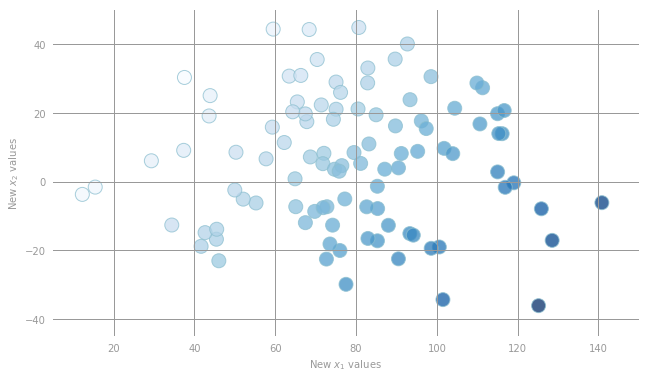

In [16]:
scores_threeD = np.asarray(threeD_scores.collect())

# generate layout and plot data
fig, ax = prepare_plot(np.arange(20, 150, 20), np.arange(-40, 110, 20))
ax.set_xlabel(r'New $x_1$ values'), ax.set_ylabel(r'New $x_2$ values')
ax.set_xlim(5, 150), ax.set_ylim(-45, 50)
plt.scatter(scores_threeD[:, 0], scores_threeD[:, 1], s=14 ** 2, c=clrs, edgecolors='#8cbfd0', alpha=0.75)
fig.show()

### (2d) Variance explained

In [17]:
def variance_explained(data, k=1):
    """Calculate the fraction of variance explained by the top `k` eigenvectors.

    Args:
        data (RDD of np.ndarray): An RDD that contains NumPy arrays which store the
            features for an observation.
        k: The number of principal components to consider.

    Returns:
        float: A number between 0 and 1 representing the percentage of variance explained
            by the top `k` eigenvectors.
    """
    components, scores, eigenvalues = pca(data)
    return float(sum(eigenvalues[0:k]))/sum(eigenvalues)

variance_random_1 = variance_explained(random_data_rdd, 1)
variance_correlated_1 = variance_explained(correlated_data, 1)
variance_random_2 = variance_explained(random_data_rdd, 2)
variance_correlated_2 = variance_explained(correlated_data, 2)
variance_threeD_2 = variance_explained(threeD_data, 2)
print ('Percentage of variance explained by the first component of random_data_rdd: {0:.1f}%'
       .format(variance_random_1 * 100))
print ('Percentage of variance explained by both components of random_data_rdd: {0:.1f}%'
       .format(variance_random_2 * 100))
print ('\nPercentage of variance explained by the first component of correlated_data: {0:.1f}%'.
       format(variance_correlated_1 * 100))
print ('Percentage of variance explained by both components of correlated_data: {0:.1f}%'
       .format(variance_correlated_2 * 100))
print ('\nPercentage of variance explained by the first two components of threeD_data: {0:.1f}%'
       .format(variance_threeD_2 * 100))

Percentage of variance explained by the first component of random_data_rdd: 58.8%
Percentage of variance explained by both components of random_data_rdd: 100.0%

Percentage of variance explained by the first component of correlated_data: 93.4%
Percentage of variance explained by both components of correlated_data: 100.0%

Percentage of variance explained by the first two components of threeD_data: 100.0%


### Part 3: Parse, inspect, and preprocess neuroscience data then perform PCA

### (3a) Load neuroscience data

In [18]:
import os
input_file = os.path.join('neuro.txt')

lines = sc.textFile(input_file)
print(lines.first()[0:100])

# Check that everything loaded properly
assert len(lines.first()) == 1397
assert lines.count() == 46460

0 0 103 103.7 103.2 102.7 103.8 102.8 103 103.3 103.8 103.2 102.1 103.5 103.2 102.7 103.1 102.2 102.


### (3b) Parse the data

In [19]:
def parse(line):
    """Parse the raw data into a (`tuple`, `np.ndarray`) pair.

    Note:
        You should store the pixel coordinates as a tuple of two ints and the elements of the pixel intensity
        time series as an np.ndarray of floats.

    Args:
        line (str): A string representing an observation.  Elements are separated by spaces.  The
            first two elements represent the coordinates of the pixel, and the rest of the elements
            represent the pixel intensity over time.

    Returns:
        tuple of tuple, np.ndarray: A (coordinate, pixel intensity array) `tuple` where coordinate is
            a `tuple` containing two values and the pixel intensity is stored in an NumPy array
            which contains 240 values.
    """
    a = line.split(" ")
    coor = (int(a[0]), int(a[1]))
    intensity = map(lambda x: float(x), a[2:])
    return (coor, np.array(intensity))

raw_data = lines.map(parse)
raw_data.cache()
entry = raw_data.first()
print('Length of movie is {0} seconds'.format(len(entry[1])))
print('Number of pixels in movie is {0:,}'.format(raw_data.count()))
print('\nFirst entry of raw_data (with only the first five values of the NumPy array):\n({0}, {1})'
       .format(entry[0], entry[1][:5]))

Length of movie is 240 seconds
Number of pixels in movie is 46,460

First entry of raw_data (with only the first five values of the NumPy array):
((0, 0), [ 103.   103.7  103.2  102.7  103.8])


### (3c) Min and max fluorescence

In [20]:
mx = raw_data.map(lambda x: max(x[1])).reduce(lambda x, y: x if x > y else y)
mn = raw_data.map(lambda x: min(x[1])).reduce(lambda x, y: x if x < y else y)

print mn, mx

100.6 940.8


### Visualization 5: Pixel intensity

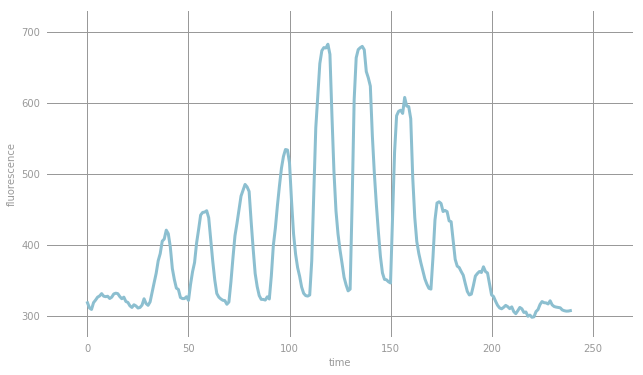

In [21]:
example = raw_data.filter(lambda (k, v): np.std(v) > 100).values().first()

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 300, 50), np.arange(300, 800, 100))
ax.set_xlabel(r'time'), ax.set_ylabel(r'fluorescence')
ax.set_xlim(-20, 270), ax.set_ylim(270, 730)
plt.plot(range(len(example)), example, c='#8cbfd0', linewidth='3.0')
fig.show()

### (3d) Fractional signal change

In [22]:
def rescale(ts):
    """Take a np.ndarray and return the standardized array by subtracting and dividing by the mean.

    Note:
        You should first subtract the mean and then divide by the mean.

    Args:
        ts (np.ndarray): Time series data (`np.float`) representing pixel intensity.

    Returns:
        np.ndarray: The times series adjusted by subtracting the mean and dividing by the mean.
    """
    mean = sum(ts)/len(ts)
    return np.array(map(lambda x: (x-mean)/mean, ts))

scaled_data = raw_data.mapValues(lambda v: rescale(v))
mn_scaled = scaled_data.map(lambda (k, v): v).map(lambda v: min(v)).min()
mx_scaled = scaled_data.map(lambda (k, v): v).map(lambda v: max(v)).max()
print mn_scaled, mx_scaled

-0.271512880125 0.905448764348


### Visualization 6: Normalized data

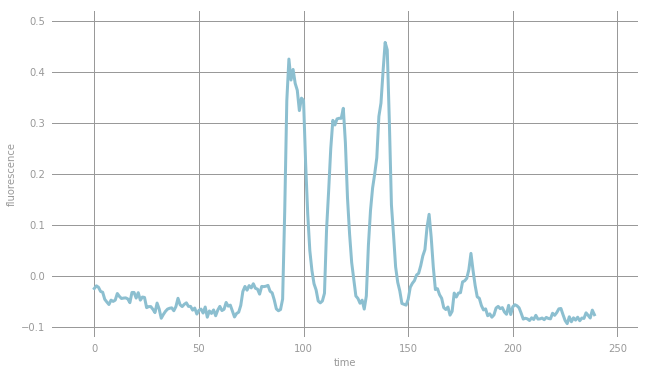

In [23]:
example = scaled_data.filter(lambda (k, v): np.std(v) > 0.1).values().first()

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 300, 50), np.arange(-.1, .6, .1))
ax.set_xlabel(r'time'), ax.set_ylabel(r'fluorescence')
ax.set_xlim(-20, 260), ax.set_ylim(-.12, .52)
plt.plot(range(len(example)), example, c='#8cbfd0', linewidth='3.0')
fig.show()

### (3e) PCA on the scaled data

In [24]:
# Run pca using scaled_data
#print scaled_data.take(1)
components_scaled, scaled_scores, eigenvalues_scaled = pca(scaled_data.map(lambda (x,y): y), 3)

### Visualization 7: Top two components as images

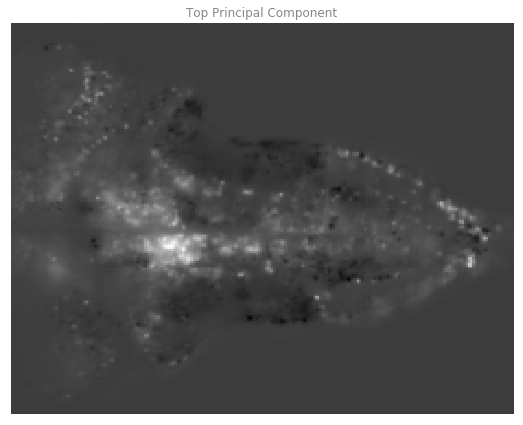

In [25]:
import matplotlib.cm as cm

scores_scaled = np.vstack(scaled_scores.collect())
image_one_scaled = scores_scaled[:, 0].reshape(230, 202).T

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hide_labels=True)
ax.grid(False)
ax.set_title('Top Principal Component', color='#888888')
image = plt.imshow(image_one_scaled, interpolation='nearest', aspect='auto', cmap=cm.gray)
fig.show()

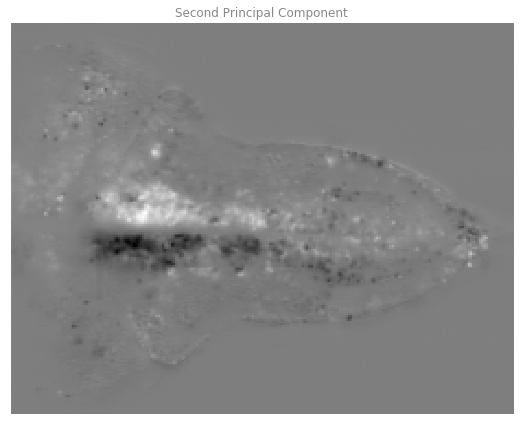

In [26]:
image_two_scaled = scores_scaled[:, 1].reshape(230, 202).T

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hide_labels=True)
ax.grid(False)
ax.set_title('Second Principal Component', color='#888888')
image = plt.imshow(image_two_scaled, interpolation='nearest', aspect='auto', cmap=cm.gray)
fig.show()

### Visualization 8: Top two components as one image

In [27]:
# Adapted from python-thunder's Colorize.transform where cmap='polar'.
# Checkout the library at: https://github.com/thunder-project/thunder and
# http://thunder-project.org/

def polar_transform(scale, img):
    """Convert points from cartesian to polar coordinates and map to colors."""
    from matplotlib.colors import hsv_to_rgb

    img = np.asarray(img)
    dims = img.shape

    phi = ((np.arctan2(-img[0], -img[1]) + np.pi/2) % (np.pi*2)) / (2 * np.pi)
    rho = np.sqrt(img[0]**2 + img[1]**2)
    saturation = np.ones((dims[1], dims[2]))

    out = hsv_to_rgb(np.dstack((phi, saturation, scale * rho)))

    return np.clip(out * scale, 0, 1)

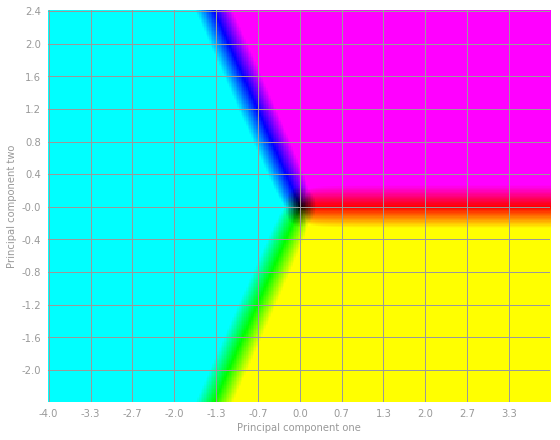

In [28]:
# Show the polar mapping from principal component coordinates to colors.
x1_abs_max = np.max(np.abs(image_one_scaled))
x2_abs_max = np.max(np.abs(image_two_scaled))

num_of_pixels = 300
x1_vals = np.arange(-x1_abs_max, x1_abs_max, (2 * x1_abs_max) / num_of_pixels)
x2_vals = np.arange(x2_abs_max, -x2_abs_max, -(2 * x2_abs_max) / num_of_pixels)
x2_vals.shape = (num_of_pixels, 1)

x1_data = np.tile(x1_vals, (num_of_pixels, 1))
x2_data = np.tile(x2_vals, (1, num_of_pixels))

# Try changing the first parameter to lower values
polar_map = polar_transform(2.0, [x1_data, x2_data])

grid_range = np.arange(0, num_of_pixels + 25, 25)
fig, ax = prepare_plot(grid_range, grid_range, figsize=(9.0, 7.2), hide_labels=True)
image = plt.imshow(polar_map, interpolation='nearest', aspect='auto')
ax.set_xlabel('Principal component one'), ax.set_ylabel('Principal component two')
grid_marks = (2 * grid_range / float(num_of_pixels) - 1.0)
x1_marks = x1_abs_max * grid_marks
x2_marks = -x2_abs_max * grid_marks
ax.get_xaxis().set_ticklabels(map(lambda x: '{0:.1f}'.format(x), x1_marks))
ax.get_yaxis().set_ticklabels(map(lambda x: '{0:.1f}'.format(x), x2_marks))
fig.show()

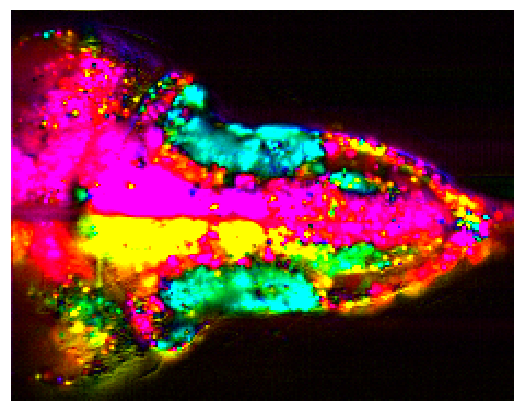

In [29]:
# Use the same transformation on the image data
# Try changing the first parameter to lower values
brainmap = polar_transform(2.0, [image_one_scaled, image_two_scaled])

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hide_labels=True)
ax.grid(False)
image = plt.imshow(brainmap,interpolation='nearest', aspect='auto')
fig.show()

## Part 4: Feature-based aggregation and PCA

### (4a) Aggregation using arrays

In [30]:
vector = np.array([0., 1., 2., 3., 4., 5.])

# Create a multi-dimensional array that when multiplied (using .dot) against vector, results in
# a two element array where the first element is the sum of the 0, 2, and 4 indexed elements of
# vector and the second element is the sum of the 1, 3, and 5 indexed elements of vector.
# This should be a 2 row by 6 column array
sum_every_other = np.array([[1,0,1,0,1,0],[0,1,0,1,0,1]])

# Create a multi-dimensional array that when multiplied (using .dot) against vector, results in a
# three element array where the first element is the sum of the 0 and 3 indexed elements of vector,
# the second element is the sum of the 1 and 4 indexed elements of vector, and the third element is
# the sum of the 2 and 5 indexed elements of vector.
# This should be a 3 row by 6 column array
sum_every_third = np.array([[1,0,0,1,0,0],[0,1,0,0,1,0],[0,0,1,0,0,1]])

# Create a multi-dimensional array that can be used to sum the first three elements of vector and
# the last three elements of vector, which returns a two element array with those values when dotted
# with vector.
# This should be a 2 row by 6 column array
sum_by_three = np.array([[1,1,1,0,0,0],[0,0,0,1,1,1]])

# Create a multi-dimensional array that sums the first two elements, second two elements, and
# last two elements of vector, which returns a three element array with those values when dotted
# with vector.
# This should be a 3 row by 6 column array
sum_by_two = np.array([[1,1,0,0,0,0],[0,0,1,1,0,0],[0,0,0,0,1,1]])

print('sum_every_other.dot(vector):\t{0}'.format(sum_every_other.dot(vector)))
print('sum_every_third.dot(vector):\t{0}'.format(sum_every_third.dot(vector)))

print('\nsum_by_three.dot(vector):\t{0}'.format(sum_by_three.dot(vector)))
print('sum_by_two.dot(vector): \t{0}'.format(sum_by_two.dot(vector)))

sum_every_other.dot(vector):	[ 6.  9.]
sum_every_third.dot(vector):	[ 3.  5.  7.]

sum_by_three.dot(vector):	[  3.  12.]
sum_by_two.dot(vector): 	[ 1.  5.  9.]


### (4b) Recreate with `np.tile` and `np.eye`

In [31]:
# Reference for what to recreate
print('sum_every_other: \n{0}'.format(sum_every_other))
print('\nsum_every_third: \n{0}'.format(sum_every_third))

sum_every_other: 
[[1 0 1 0 1 0]
 [0 1 0 1 0 1]]

sum_every_third: 
[[1 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 1 0 0 1]]


In [32]:
# Use np.tile and np.eye to recreate the arrays
sum_every_other_tile = np.tile(np.eye(2),3)
sum_every_third_tile = np.tile(np.eye(3),2)

print(sum_every_other_tile)
print('sum_every_other_tile.dot(vector): {0}'.format(sum_every_other_tile.dot(vector)))
print '\n', sum_every_third_tile
print('sum_every_third_tile.dot(vector): {0}'.format(sum_every_third_tile.dot(vector)))

[[ 1.  0.  1.  0.  1.  0.]
 [ 0.  1.  0.  1.  0.  1.]]
sum_every_other_tile.dot(vector): [ 6.  9.]

[[ 1.  0.  0.  1.  0.  0.]
 [ 0.  1.  0.  0.  1.  0.]
 [ 0.  0.  1.  0.  0.  1.]]
sum_every_third_tile.dot(vector): [ 3.  5.  7.]


### (4c) Recreate with `np.kron`

In [33]:
# Reference for what to recreate
print 'sum_by_three: \n{0}'.format(sum_by_three)
print '\nsum_by_two: \n{0}'.format(sum_by_two)

sum_by_three: 
[[1 1 1 0 0 0]
 [0 0 0 1 1 1]]

sum_by_two: 
[[1 1 0 0 0 0]
 [0 0 1 1 0 0]
 [0 0 0 0 1 1]]


In [34]:
# Use np.kron, np.eye, and np.ones to recreate the arrays
sum_by_three_kron = np.kron(np.eye(2), np.ones((1,3)))
sum_by_two_kron = np.kron(np.eye(3), np.ones((1,2)))

print sum_by_three_kron
print 'sum_by_three_kron.dot(vector): {0}'.format(sum_by_three_kron.dot(vector))
print '\n', sum_by_two_kron
print 'sum_by_two_kron.dot(vector): {0}'.format(sum_by_two_kron.dot(vector))

[[ 1.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  1.]]
sum_by_three_kron.dot(vector): [  3.  12.]

[[ 1.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.]]
sum_by_two_kron.dot(vector): [ 1.  5.  9.]


### (4d) Aggregate by time

In [35]:
# Create a multi-dimensional array to perform the aggregation
T = np.tile(np.eye(20),12)

# Transform scaled_data using T.  Make sure to retain the keys.
time_data = scaled_data.mapValues(lambda x: T.dot(x))

time_data.cache()
print time_data.count()
print time_data.first()

46460
((0, 0), array([ 0.00802155,  0.00607693, -0.0075354 ,  0.00121539,  0.02163388,
        0.00121539, -0.03087082,  0.00510462,  0.01191079,  0.02455081,
       -0.0182308 ,  0.00802155, -0.00948002, -0.00948002,  0.02163388,
       -0.02212004,  0.00704924,  0.00121539, -0.01142464, -0.00850771]))


### (4e) Obtain a compact representation

In [36]:
components_time, time_scores, eigenvalues_time = pca(time_data.map(lambda (x,y): y), 3)

print 'components_time: (first five) \n{0}'.format(components_time[:5, :])
print ('\ntime_scores (first three): \n{0}'
       .format('\n'.join(map(str, time_scores.take(3)))))
print '\neigenvalues_time: (first five) \n{0}'.format(eigenvalues_time[:5])

components_time: (first five) 
[[ 0.27392702 -0.16152431  0.01388556]
 [ 0.09941893 -0.31968127 -0.34738824]
 [-0.03376505 -0.32933108 -0.35606954]
 [-0.12092744 -0.2845482  -0.27232364]
 [-0.18219248 -0.22998061 -0.12248985]]

time_scores (first three): 
[-0.00720617 -0.00292979 -0.00223645]
[ 0.02353076 -0.00197457  0.00362094]
[ 0.01310623  0.00123069 -0.00582974]

eigenvalues_time: (first five) 
[0.77528990735843994, 0.05038881175277992, 0.01173423377622294, 0.0059711048110200554, 0.0013807346261313098]


### Visualization 9: Top two components by time

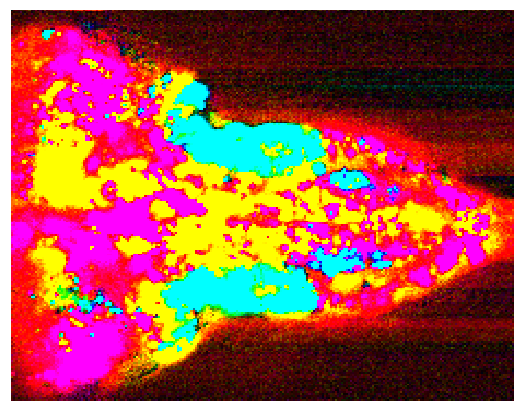

In [37]:
scores_time = np.vstack(time_scores.collect())
image_one_time = scores_time[:, 0].reshape(230, 202).T
image_two_time = scores_time[:, 1].reshape(230, 202).T
brainmap = polar_transform(3, [image_one_time, image_two_time])

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hide_labels=True)
ax.grid(False)
image = plt.imshow(brainmap,interpolation='nearest', aspect='auto')
fig.show()

### (4f) Aggregate by direction

In [38]:
# Create a multi-dimensional array to perform the aggregation
D = np.kron(np.eye(12), np.ones((1,20)))

# Transform scaled_data using D.  Make sure to retain the keys.
direction_data = scaled_data.mapValues(lambda x: D.dot(x))

direction_data.cache()
print direction_data.count()
print direction_data.first()

46460
((0, 0), array([ 0.03346365,  0.03638058, -0.02195799, -0.02487492,  0.00721129,
        0.00332206, -0.02098568,  0.00915591, -0.00542873, -0.01029027,
        0.0081836 , -0.01417951]))


### (4g) Compact representation of direction data

In [39]:
components_direction, direction_scores, eigenvalues_direction = pca(direction_data.map(lambda (x,y): y), 3)

print 'components_direction: (first five) \n{0}'.format(components_direction[:5, :])
print ('\ndirection_scores (first three): \n{0}'
       .format('\n'.join(map(str, direction_scores.take(3)))))
print '\neigenvalues_direction: (first five) \n{0}'.format(eigenvalues_direction[:5])

components_direction: (first five) 
[[-0.25952179  0.16201941  0.24947433]
 [-0.31369506 -0.09185175  0.29464223]
 [-0.21716693 -0.35944645  0.35296454]
 [-0.11517273 -0.37356905  0.07169062]
 [ 0.02996577 -0.36272623 -0.14783897]]

direction_scores (first three): 
[-0.01622513  0.01322998  0.01322204]
[ 0.00999482  0.0652367  -0.04524758]
[ 0.004646    0.05751097  0.00756383]

eigenvalues_direction: (first five) 
[0.96411048310020386, 0.77613553163001781, 0.12762987006740523, 0.097759242627332016, 0.043336910292899183]


### Visualization 10: Top two components by direction

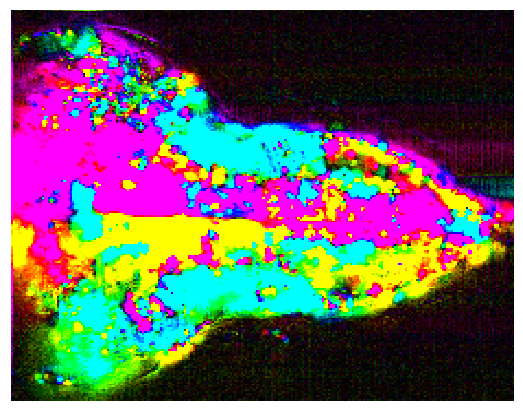

In [40]:
scores_direction = np.vstack(direction_scores.collect())
image_one_direction = scores_direction[:, 0].reshape(230, 202).T
image_two_direction = scores_direction[:, 1].reshape(230, 202).T
brainmap = polar_transform(2, [image_one_direction, image_two_direction])
# with thunder: Colorize(cmap='polar', scale=2).transform([image_one_direction, image_two_direction])

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 10, 1), np.arange(0, 10, 1), figsize=(9.0, 7.2), hide_labels=True)
ax.grid(False)
image = plt.imshow(brainmap, interpolation='nearest', aspect='auto')
fig.show()